In [1060]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft,fftfreq,ifft
from scipy import signal
from scipy.special import rel_entr
from sklearn.preprocessing import normalize
import librosa
import librosa.display

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as TorTrans



In [1061]:
def plot_fft(y,fs):
    N=len(y)
    T = 1/fs
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(14,4))
    plt.scatter(xf, 2.0/N * np.abs(yf[0:N//2]))
    return


def segment_chirp(recieved_wave,fs, thresh=0.0015, delay= 0.8):
    s = normalize([recieved_wave])[0][int(delay*fs):int(2*fs)]
    chirp_confirm=False
    P=0
    while(chirp_confirm==False):
        key = np.where(s>thresh)[0][0]
        curr = key + int(0.12*fs)
        if (s[curr]>thresh):
            curr = curr+int(0.12*fs)
            if (s[curr]>thresh):
                curr = curr+int(0.12*fs)
                if (s[curr]<thresh):
                    break
                    chirp_confirm=True
                    
        P = P + curr
        s = s[curr:]
        
    P = P + key +  int(delay*fs)-int(0.02*fs)
        
    return( P,P+int(0.46*fs))


def minmax_normalize(data_set):
    data_normalized = (data_set-np.min(data_set))/(np.max(data_set)-np.min(data_set))
    return data_normalized

def standardize(data_set):
    data_normalize = (data_set-np.mean(data_set))/np.std(data_set)
    return data_normalize

def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def analyze(str_filename,Clean_space):


    df_0 = pd.read_csv(Clean_space)
    df = pd.read_csv(str_filename)
    fs = 62500.0
    T = 1/fs
    N= df.shape[0]
    y = np.array(df.Audio) - np.array(df_0.Audio)
    t = np.arange(0,N)*T


    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    #Band Pass filtering
    
    lowcut = 15000.0
    highcut = 19000.0

    b, a = butter_bandpass(lowcut, highcut, fs, order=12)
    w, h = signal.freqz(b, a, worN=30000)

    y_filtered_sound = butter_bandpass_filter(y, lowcut, highcut, fs, order=12)

    yf_filtered = fft(y_filtered_sound)
    xf_filtered = fftfreq(N, T)[:N//2]

    # Plot the frequency response and waveforms
    fig,ax = plt.subplots(4,1, figsize=(16,16))
    ax[0].plot(t, y)
    ax[0].title.set_text('Recieved Echo')

    ax[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax[1].title.set_text('FFT of the Recieved Echo')

    ax[2].plot(t, y_filtered_sound)
    ax[2].title.set_text('BandPass filtered Recieved Echo')

    ax[3].plot(xf_filtered, 2.0/N * np.abs(yf_filtered[0:N//2]))
    ax[3].set_xlim((10000,22000))
    ax[3].title.set_text('FFT of BP-Recieved Echo')

    plt.show()

def butter_lowpass(cutoff, fs , order=4):
    nyq_freq = fs/2
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y  

def extract_peak_frequency(data, sampling_rate):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data))
    
    peak_coefficient = np.argmax(np.abs(fft_data))
    peak_freq = freqs[peak_coefficient]
    
    return abs(peak_freq * sampling_rate)

def Phase_lag_Hilbert(x1,x2,sampling_rate):
    
    x1h = signal.hilbert(x1)
    x2h = signal.hilbert(x2)
    omega = (extract_peak_frequency(x1,sampling_rate) + extract_peak_frequency(x2,sampling_rate))/2
             
    c = np.inner( x1h, np.conj(x2h) ) / np.sqrt( np.inner(x1h,np.conj(x1h)) * np.inner(x2h,np.conj(x2h)) )
    phase_diff = np.angle(c)/(np.pi*2*omega)
    return(-phase_diff * sampling_rate) # return the delayed number of sample points


def Phase_lag_xcc(A,B,sampling_rate):
    
    # Find cross-correlation
    xcorr = signal.correlate(A, B)
    lags = signal.correlation_lags(len(A), len(B))
    # delta time array to match xcorr
    omega = (extract_peak_frequency(A,sampling_rate) + extract_peak_frequency(B,sampling_rate))/2

    recovered_time_shift = lags[np.argmax(xcorr)]

    return(recovered_time_shift*(1/1000)*(np.pi*2*omega))


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)







In [1062]:
F_min = 16000 # 16KHz
F_max = 22000 # 22KHz
sampling_rate = 100000 # 100KHz
Fs = 100000  # 100KHz
FMCW_duration = 0.08
silent_duration = 0.02

In [1063]:
#def normalize(x):
   # return(x)

In [1064]:
sound,sr = librosa.load("TR Type 1_filtered.wav",sr=sampling_rate)

In [1065]:
Tr_chirp =normalize([sound[:int(0.4*sampling_rate)]])[0]

In [1066]:
def read_data(str_file_name):
    df = pd.read_csv(str_file_name)
    df=df.rename(columns={'Time':'time', 'Channel A':'ChnA', 'Channel B':'ChnB'})
    t = np.array(df.time[1:]).astype(float)
    Chn_A = np.array(df.ChnA[1:]).astype(float)
    Chn_B = np.array(df.ChnB[1:]).astype(float)
   
    return(t/1000 , Chn_A, Chn_B)

def get_data(filename):
    dA_1,dB_1 = np.array([]),np.array([])
    for i in range(1,3):
        s = str(i)
        file_name = filename + ".csv"
        time,A,B = read_data(file_name)
        dA_1,dB_1 = np.concatenate((dA_1,A)),np.concatenate((dB_1,B))
    return(dA_1,dB_1)

In [1067]:
Intfer_A_d,Intfer_B_d = get_data("Attemp 2\Data\Ifer 50")

Text(0.5, 1.0, 'Transmitted (Interferance)')

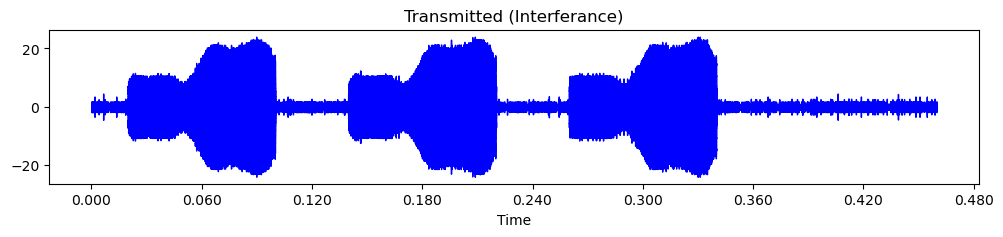

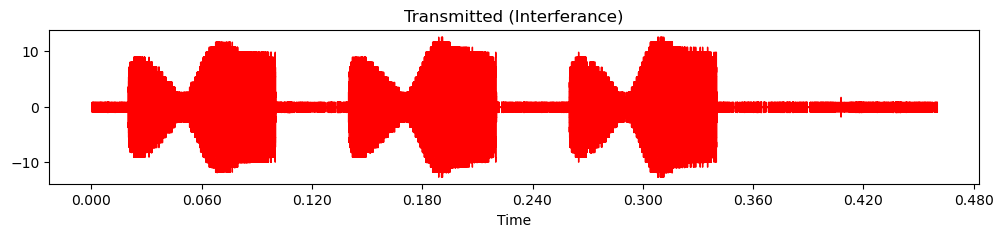

In [1068]:
ind = segment_chirp(Intfer_A_d,Fs)
Intfer_A = ([Intfer_A_d])[0][ind[0]:ind[1]]
Intfer_B = ([Intfer_B_d])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Intfer_A,sr=Fs,color="blue")
plt.title("Transmitted (Interferance)")
#plt.xlim((1.478,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Intfer_B,sr=Fs,color="red")
plt.title("Transmitted (Interferance)")
#plt.xlim((0.49,0.89))

In [1069]:
Tes_no = "30"
ref_A0d , ref_B0d = get_data("Attemp 2\Data\T1\Ref")

Ref_A_1_d,Ref_B_1_d = get_data("Attemp 2\Data\T"+Tes_no+"\Ref")
Relax_Ad,Relax_Bd = get_data("Attemp 2\Data\T"+Tes_no+"\Close")
OpM_Ad,OpM_Bd = get_data("Attemp 2\Data\T"+Tes_no+"\Open")
Laugh_Ad,Laugh_Bd = get_data("Attemp 2\Data\T"+Tes_no+"\Lagh")
Side_Ad , Side_Bd = get_data("Attemp 2\Data\T"+Tes_no+"\Side")


In [1070]:
ind = segment_chirp(ref_A0d,Fs,delay=1)
ref_A0 = ([ref_A0d])[0][ind[0]:ind[1]]
ref_B0 = ([ref_B0d])[0][ind[0]:ind[1]]

Text(0.5, 1.0, 'Referance Echo')

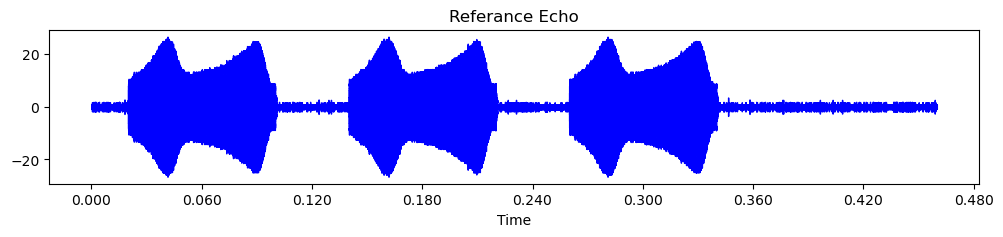

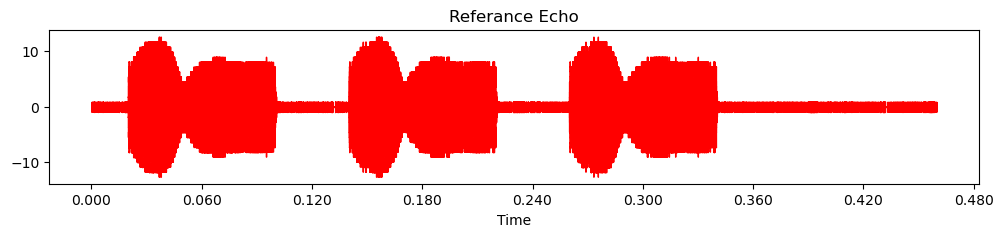

In [1071]:
Ref_A_1_dd , Ref_B_1_dd = butter_bandpass_filter(Ref_A_1_d,F_min,F_max,Fs,order=5),butter_bandpass_filter(Ref_B_1_d,F_min,F_max,Fs,order=5)
ind = segment_chirp(Ref_A_1_d ,Fs,thresh=0.0015,delay=0.5)
# 0,1,2 0.3
Ref_A_1 = ([Ref_A_1_d])[0][ind[0]:ind[1]]
Ref_B_1 = ([Ref_B_1_d])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Ref_A_1,sr=Fs,color="blue")
plt.title("Referance Echo")
#plt.xlim((0.491,1))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Ref_B_1,sr=Fs,color="red")
plt.title("Referance Echo")
#plt.xlim((0.49,0.89))



Text(0.5, 1.0, 'No expression')

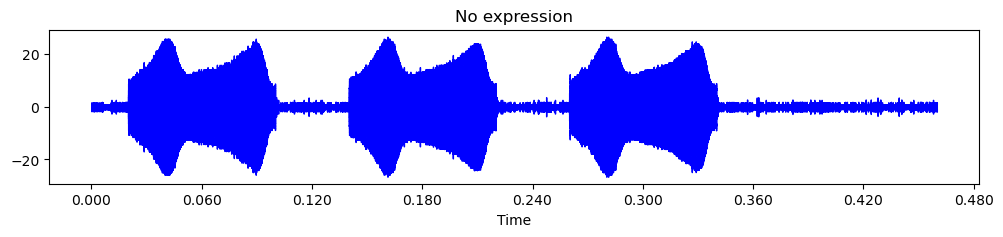

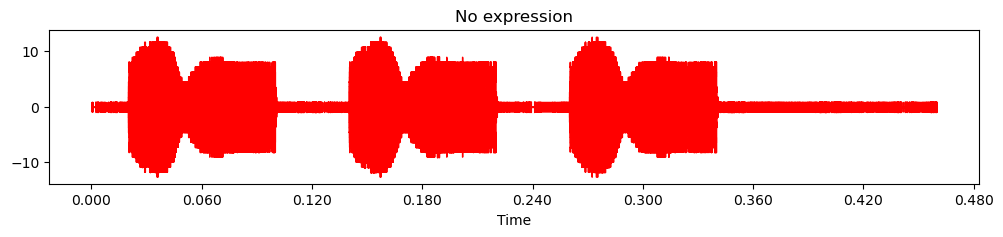

In [1072]:
Relax_Add , Relax_Bdd = butter_bandpass_filter(Relax_Ad,F_min,F_max,Fs,order=7),butter_bandpass_filter(Relax_Bd,F_min,F_max,Fs,order=7)
ind = segment_chirp(Relax_Ad,Fs,thresh=0.0013,delay=0.6)
Relax_A = ([Relax_Ad])[0][ind[0]:ind[1]]
Relax_B = ([Relax_Bd])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Relax_A,sr=Fs,color="blue")
plt.title("No expression")
#plt.xlim((1.383,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Relax_B,sr=Fs,color="red")
plt.title("No expression")
#plt.xlim((0.7305,1.122))

Text(0.5, 1.0, 'Open Mouth')

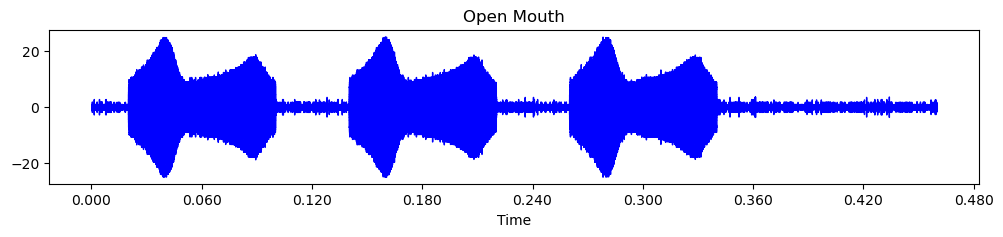

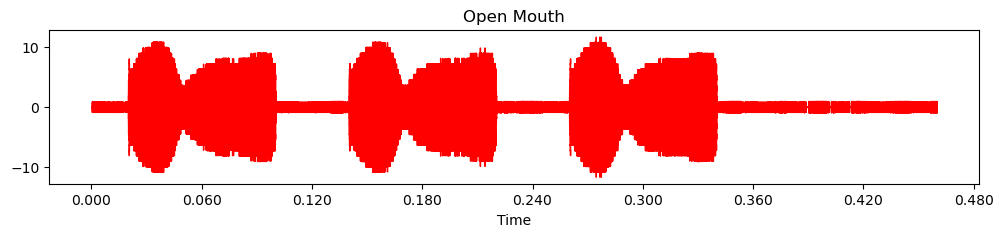

In [1073]:
OpM_Add , OpM_Bdd = butter_bandpass_filter(OpM_Ad,F_min,F_max,Fs,order=7),butter_bandpass_filter(OpM_Bd,F_min,F_max,Fs,order=7)
ind = segment_chirp(OpM_Ad,Fs,thresh= 0.0015,delay=0.1)
#0,2= 0.0017,delay=0.7
OpM_A = ([OpM_Ad])[0][ind[0]:ind[1]]
OpM_B = ([OpM_Bd])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(OpM_A,sr=Fs,color="blue")
plt.title("Open Mouth")
#plt.xlim((1.102,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(OpM_B,sr=Fs,color="red")
plt.title("Open Mouth")
#plt.xlim((2.29,3))

Text(0.5, 1.0, 'Laugh')

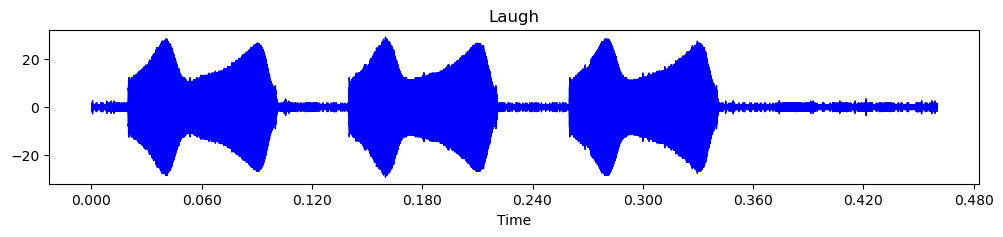

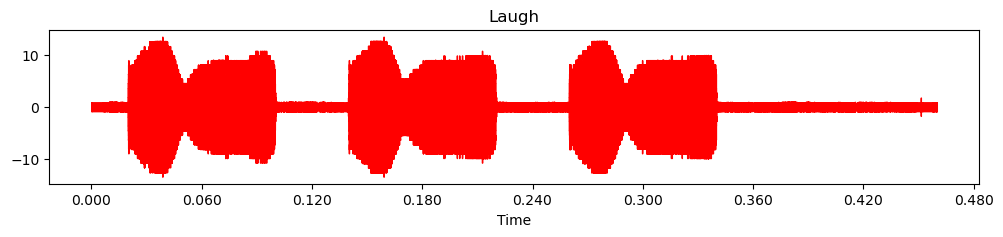

In [1074]:
Laugh_Add , Laugh_Bdd= butter_bandpass_filter(Laugh_Ad,F_min,F_max,Fs,order=7),butter_bandpass_filter(Laugh_Bd,F_min,F_max,Fs,order=7)

ind = segment_chirp(Laugh_Ad,Fs,thresh=0.0015,delay=0.6) # 2,0 esh=0.0016,delay=0.8
Laugh_A = ([Laugh_Ad])[0][ind[0]:ind[1]]
Laugh_B = ([Laugh_Bd])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Laugh_A,sr=Fs,color="blue")
plt.title("Laugh")
#plt.xlim((1.227,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Laugh_B,sr=Fs,color="red")
plt.title("Laugh")
#plt.xlim((0.49,0.89))

Text(0.5, 1.0, 'Side')

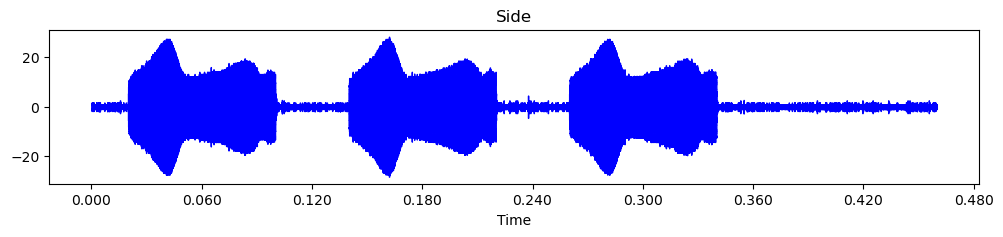

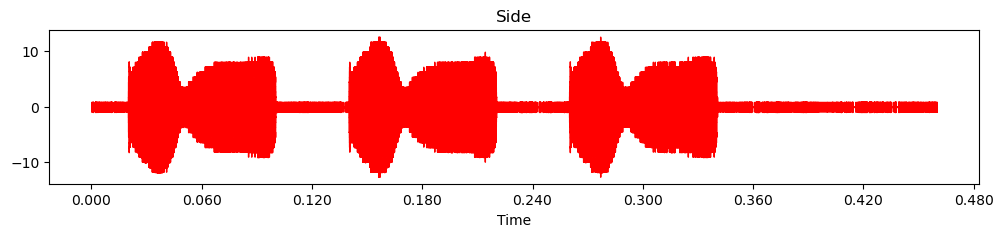

In [1075]:
Side_Add , Side_Bdd= butter_bandpass_filter(Side_Ad,F_min,F_max,Fs,order=7),butter_bandpass_filter(Side_Bd,F_min,F_max,Fs,order=7)

ind = segment_chirp(Side_Ad,Fs,thresh=0.0013,delay=0.9) # 0,2 delay=0.6
Side_A = ([Side_Ad])[0][ind[0]:ind[1]]
Side_B = ([Side_Bd])[0][ind[0]:ind[1]]

plt.figure(figsize=(12,2))
librosa.display.waveshow(Side_A,sr=Fs,color="blue")
plt.title("Side")
#plt.xlim((1.219,2))

plt.figure(figsize=(12,2))
librosa.display.waveshow(Side_B,sr=Fs,color="red")
plt.title("Side")
#plt.xlim((0.49,0.89))

In [1076]:
def Additionally_average(data_set,fs):
    fs = int(fs)
    averaged_data = data_set[: int(0.120*fs)]

    for i in range(1,3):
     
        averaged_data= averaged_data + data_set[int((0.120*i)*fs) : int((0.120*(i+1))*fs)]
    return(averaged_data.astype(float)/3)

Intfer_A , Intfer_B= Additionally_average(Intfer_A,Fs) , Additionally_average(Intfer_B,Fs)
ref_A0 , ref_B0 = Additionally_average(ref_A0,Fs) , Additionally_average(ref_B0,Fs)

Ref_A_1 , Ref_B_1 = Additionally_average(Ref_A_1,Fs) , Additionally_average(Ref_B_1,Fs)
Relax_A , Relax_B = Additionally_average(Relax_A,Fs) , Additionally_average(Relax_B,Fs)
OpM_A , OpM_B =     Additionally_average(OpM_A,Fs) , Additionally_average(OpM_B,Fs)
Laugh_A , Laugh_B =   Additionally_average(Laugh_A,Fs) , Additionally_average(Laugh_B,Fs)
Side_A , Side_B =   Additionally_average(Side_A,Fs) , Additionally_average(Side_B,Fs)
Tr_chirp = Additionally_average(Tr_chirp,Fs)

Filtering

In [1077]:
filt_Tr_chirp = butter_bandpass_filter(Tr_chirp,F_min,F_max,Fs,order=9)*(2000)

filt_ref_A0 , filt_ref_B0 = butter_bandpass_filter(ref_A0,F_min,F_max,Fs,order=9) , butter_bandpass_filter(ref_B0,F_min,F_max,Fs,order=9)

filt_IF_A , filt_IF_B = butter_bandpass_filter(Intfer_A,F_min,F_max,Fs,order=9),butter_bandpass_filter(Intfer_B,F_min,F_max,Fs,order=9)
filt_Ref_A , filt_Ref_B = butter_bandpass_filter(Ref_A_1,F_min,F_max,Fs,order=9),butter_bandpass_filter(Ref_B_1,F_min,F_max,Fs,order=9)
filt_Relax_A ,filt_Relax_B  = butter_bandpass_filter(Relax_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Relax_B,F_min,F_max,Fs,order=9)
filt_OpM_A ,filt_OpM_B  = butter_bandpass_filter(OpM_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(OpM_B,F_min,F_max,Fs,order=9)
filt_Laugh_A ,filt_Laugh_B  = butter_bandpass_filter(Laugh_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Laugh_B,F_min,F_max,Fs,order=9)
filt_Side_A ,filt_Side_B  = butter_bandpass_filter(Side_A,F_min,F_max,Fs,order=9) , butter_bandpass_filter(Side_B,F_min,F_max,Fs,order=9)

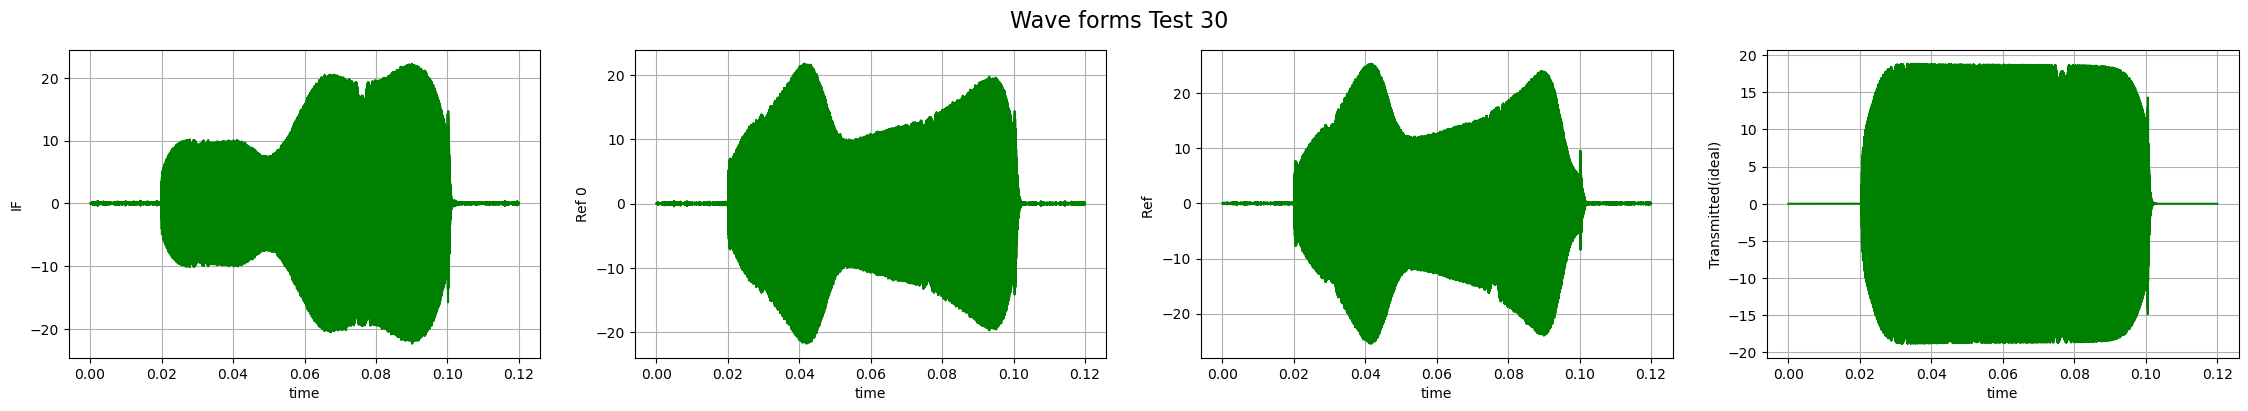

In [1078]:
t = np.linspace(0,0.12,int(0.12*Fs))

fig, axs = plt.subplots(1, 4,figsize=(28,4))
fig.suptitle('Wave forms Test '+Tes_no, fontsize=16)

axs[0].plot(t,filt_IF_A,color="green")
axs[0].set_xlabel('time')
axs[0].set_ylabel('IF')
axs[0].grid(True)

axs[1].plot(t,filt_ref_A0,color="green")
axs[1].set_xlabel('time')
axs[1].set_ylabel('Ref 0')
axs[1].grid(True)

axs[2].plot(t,filt_Ref_A,color="green")
axs[2].set_xlabel('time')
axs[2].set_ylabel('Ref ')
axs[2].grid(True)

axs[3].plot(t,filt_Tr_chirp,color="green")
axs[3].set_xlabel('time')
axs[3].set_ylabel('Transmitted(ideal)')
axs[3].grid(True)

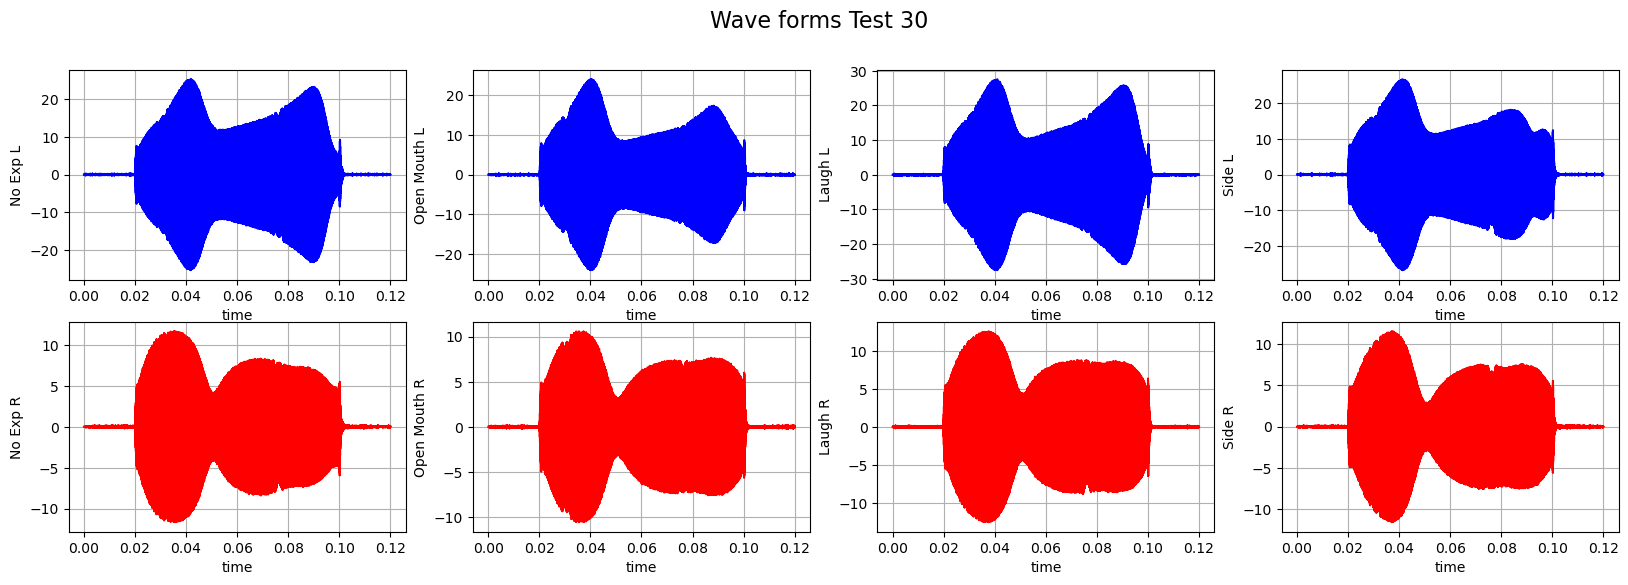

In [1079]:
t = np.linspace(0,0.12,int(0.12*Fs))

fig, axs = plt.subplots(2,4,figsize=(20,6))
fig.suptitle('Wave forms Test '+Tes_no, fontsize=16)

axs[0,0].plot(t,filt_Relax_A,color="blue")
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('No Exp L')
axs[0,0].grid(True)

axs[1,0].plot(t,filt_Relax_B,color="red")
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('No Exp R')
axs[1,0].grid(True)

axs[0,1].plot(t,filt_OpM_A,color="blue")
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('Open Mouth L')
axs[0,1].grid(True)

axs[1,1].plot(t,filt_OpM_B,color="red")
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('Open Mouth R')
axs[1,1].grid(True)

axs[0,2].plot(t,filt_Laugh_A,color="blue")
axs[0,2].set_xlabel('time')
axs[0,2].set_ylabel('Laugh L')
axs[0,2].grid(True)

axs[1,2].plot(t,filt_Laugh_B,color="red")
axs[1,2].set_xlabel('time')
axs[1,2].set_ylabel('Laugh R')
axs[1,2].grid(True)

axs[0,3].plot(t,filt_Side_A,color="blue")
axs[0,3].set_xlabel('time')
axs[0,3].set_ylabel('Side L')
axs[0,3].grid(True)

axs[1,3].plot(t,filt_Side_B,color="red")
axs[1,3].set_xlabel('time')
axs[1,3].set_ylabel('Side R')
axs[1,3].grid(True)

plt.savefig("Attemp 2\Results\Wave form "+Tes_no+".png")

plt.show()

In [1080]:
def Amp_envelop_detector(audiowave,farame_size,hoplength):  
    Amp_env = []
        # Calculating the Amplitude Envelop iteratively
    for i in range (0,len(audiowave),hoplength):
        Amp_env.append(max(audiowave[i:i+farame_size]))
    
    return np.array(Amp_env)

    

In [1081]:
F_size , H_length = 128, 16

env_relax_A , env_relax_B = Amp_envelop_detector(filt_Relax_A, F_size ,  H_length) , Amp_envelop_detector(filt_Relax_B, F_size ,  H_length)
env_opm_A , env_opm_B = Amp_envelop_detector(filt_OpM_A, F_size ,  H_length) , Amp_envelop_detector(filt_OpM_B, F_size ,  H_length)
env_laugh_A , env_laugh_B = Amp_envelop_detector(filt_Laugh_A, F_size ,  H_length) , Amp_envelop_detector(filt_Laugh_B, F_size ,  H_length)
env_side_A , env_side_B = Amp_envelop_detector(filt_Side_A, F_size ,  H_length) , Amp_envelop_detector(filt_Side_B, F_size ,  H_length)

t_amp = librosa.frames_to_time(range(0,env_relax_A.size) , hop_length = H_length)

env_relax_A.size

750

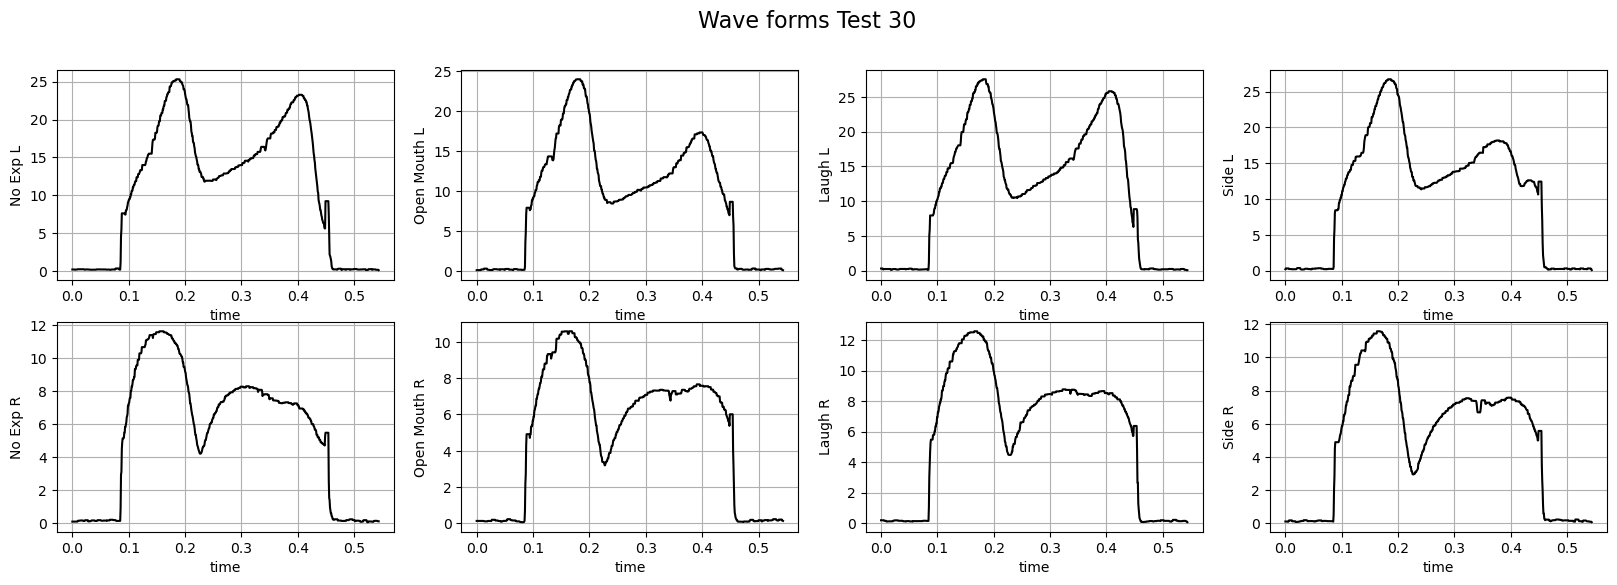

In [1082]:
fig, axs = plt.subplots(2,4,figsize=(20,6))
fig.suptitle('Wave forms Test '+Tes_no, fontsize=16)

axs[0,0].plot(t_amp,env_relax_A, color="black")
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('No Exp L')
axs[0,0].grid(True)


axs[1,0].plot(t_amp,env_relax_B, color="black")
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('No Exp R')
axs[1,0].grid(True)


axs[0,1].plot(t_amp,env_opm_A, color="black")
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('Open Mouth L')
axs[0,1].grid(True)

axs[1,1].plot(t_amp,env_opm_B, color="black")
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('Open Mouth R')
axs[1,1].grid(True)


axs[0,2].plot(t_amp,env_laugh_A, color="black")
axs[0,2].set_xlabel('time')
axs[0,2].set_ylabel('Laugh L')
axs[0,2].grid(True)


axs[1,2].plot(t_amp,env_laugh_B, color="black")
axs[1,2].set_xlabel('time')
axs[1,2].set_ylabel('Laugh R')
axs[1,2].grid(True)


axs[0,3].plot(t_amp,env_side_A, color="black")
axs[0,3].set_xlabel('time')
axs[0,3].set_ylabel('Side L')
axs[0,3].grid(True)


axs[1,3].plot(t_amp,env_side_B, color="black")
axs[1,3].set_xlabel('time')
axs[1,3].set_ylabel('Side R')
axs[1,3].grid(True)

plt.show()

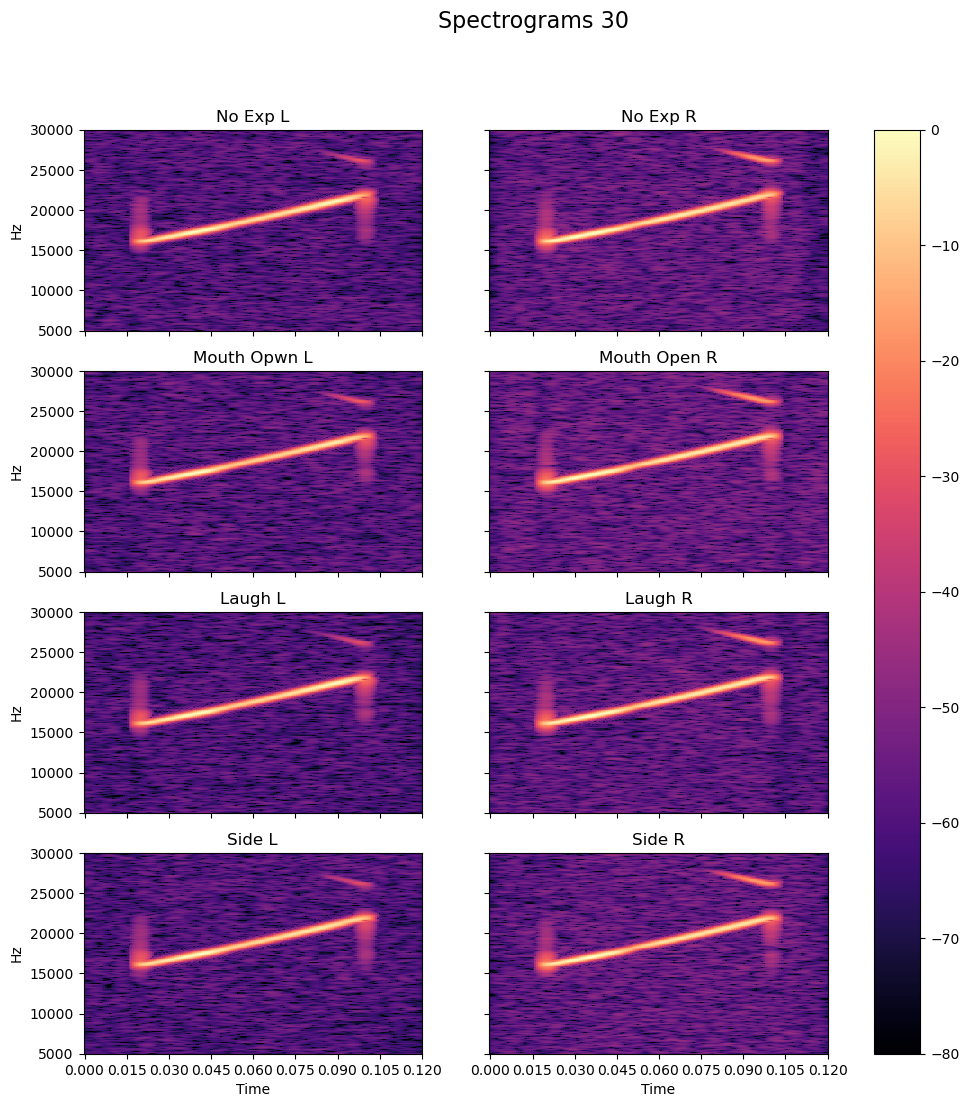

In [1083]:
frameSize = 1024
hopSize = 64


fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(12,12),sharex=True,sharey=True)
fig.suptitle('Spectrograms '+Tes_no, fontsize=16)

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(Relax_A, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[0,0])
ax[0,0].set(title='No Exp L')
ax[0,0].set_ylim((5000,30000))
ax[0,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(Relax_B, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[0,1],key='Eb:maj')
ax[0,1].set(title='No Exp R')
ax[0,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(OpM_A, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[1,0])
ax[1,0].set(title='Mouth Opwn L')
ax[1,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(OpM_B, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[1,1],key='Eb:maj')
ax[1,1].set(title='Mouth Open R')
ax[1,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(Laugh_A, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[2,0])
ax[2,0].set(title='Laugh L')
ax[2,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(Laugh_B, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[2,1],key='Eb:maj')
ax[2,1].set(title='Laugh R')
ax[2,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(Side_A, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[3,0])
ax[3,0].set(title='Side L')
ax[3,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(Side_B, n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='linear', x_axis='time',sr=Fs, hop_length = hopSize , ax=ax[3,1],key='Eb:maj')
ax[3,1].set(title='Side R')
ax[3,1].label_outer()

plt.savefig("Attemp 2\Results\Specgrams "+Tes_no+".png")

fig.colorbar(img, ax=ax)







TF Modeling

In [1084]:
T= 1/Fs
N=len(filt_Relax_A)

fifa , fifb = fft(filt_IF_A) , fft(filt_IF_B)

F_ref_A0 , F_ref_B0 = fft(filt_ref_A0) , fft(filt_ref_B0)

F_ref_A , F_ref_B = fft(filt_Ref_A) , fft(filt_Ref_B)
F_relax_A , F_relax_B = fft(filt_Relax_A) , fft(filt_Relax_B)
F_OpM_A , F_OpM_B = fft(filt_OpM_A) , fft(filt_OpM_B)
F_Laugh_A , F_Laugh_B = fft(filt_Laugh_A) , fft(filt_Laugh_B)
F_Side_A , F_Side_B = fft(filt_Side_A) , fft(filt_Side_B)
Transmit_f = fft(Tr_chirp)

X_f = fftfreq(N,T)
xf = fftfreq(N, T)[:N//2]


def get_TF(signalA_fft,signalB_fft):

    A , B = F_ref_A0/F_ref_A , F_ref_B0/F_ref_B

    tfA= ((signalA_fft*A)-fifa)/ fifa

    tfB = ((signalB_fft*B)-fifb)/ fifb

    return(tfA,tfB)


TF_relax_A , TF_relax_B   = get_TF(F_relax_A,F_relax_B)
  

TF_Side_A , TF_Side_B    = get_TF(F_Side_A ,F_Side_B)


TF_OpM_A , TF_OpM_B = get_TF(F_OpM_A  ,F_OpM_B )


TF_Laugh_A ,TF_Laugh_B = get_TF(F_Laugh_A ,F_Laugh_B ) 


In [1085]:
def filting(array,xf):
    a = np.zeros(len(array))
    for i in range(len(xf)):
        if ((xf[i])>F_min and (xf[i])<F_max):
            a[i]=(array[i])  
    return a

Left Ear

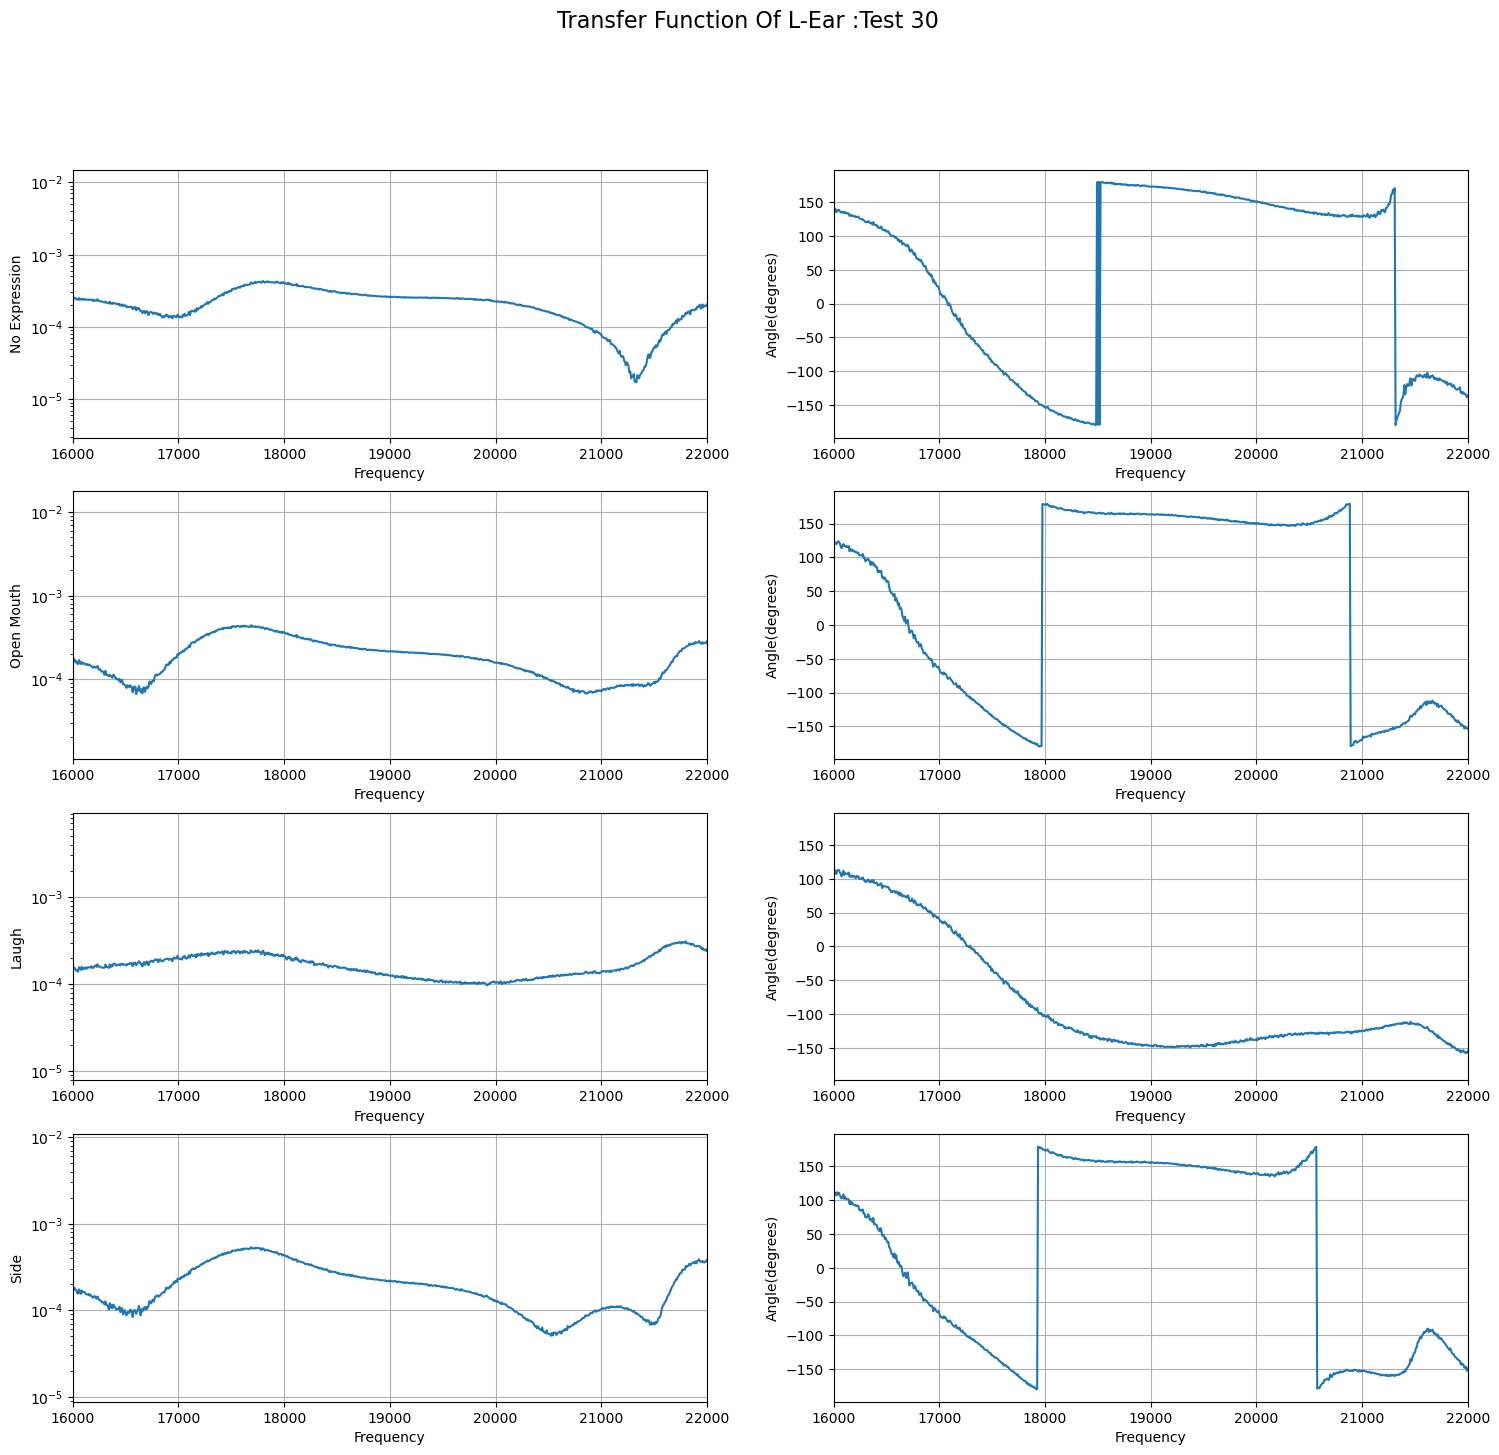

In [1086]:

fig, axs = plt.subplots(4, 2,figsize=(18,16))
fig.suptitle('Transfer Function Of L-Ear :Test '+Tes_no, fontsize=16)

axs[0,0].semilogy(xf,(2/N)*abs(TF_relax_A[:N//2]))
axs[0,0].set_xlim((F_min,F_max))
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_ylabel('No Expression')
axs[0,0].grid(True)

axs[0,1].plot(xf,(180/np.pi)*np.angle(TF_relax_A[:N//2]))
axs[0,1].set_xlim((F_min,F_max))
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Angle(degrees)')
axs[0,1].grid(True)

axs[1,0].semilogy(xf,(2/N)*abs(TF_OpM_A[:N//2]))
axs[1,0].set_xlim((F_min,F_max))
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_ylabel('Open Mouth')
axs[1,0].grid(True)

axs[1,1].plot(xf,(180/np.pi)*np.angle(TF_OpM_A[:N//2]))
axs[1,1].set_xlim((F_min,F_max))
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Angle(degrees)')
axs[1,1].grid(True)

axs[2,0].semilogy(xf,(2/N)*abs(TF_Laugh_A[:N//2]))
axs[2,0].set_xlim((F_min,F_max))
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_ylabel('Laugh')
axs[2,0].grid(True)

axs[2,1].plot(xf,(180/np.pi)*np.angle(TF_Laugh_A[:N//2]))
axs[2,1].set_xlim((F_min,F_max))
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_ylabel('Angle(degrees)')
axs[2,1].grid(True)

axs[3,0].semilogy(xf,(2/N)*abs(TF_Side_A[:N//2]))
axs[3,0].set_xlim((F_min,F_max))
axs[3,0].set_xlabel('Frequency')
axs[3,0].set_ylabel('Side')
axs[3,0].grid(True)

axs[3,1].plot(xf,(180/np.pi)*np.angle(TF_Side_A[:N//2]))
axs[3,1].set_xlim((F_min,F_max))
axs[3,1].set_xlabel('Frequency')
axs[3,1].set_ylabel('Angle(degrees)')
axs[3,1].grid(True)

plt.savefig("Attemp 2\Results\TF_L "+Tes_no+".png")

plt.show()


Right Ear

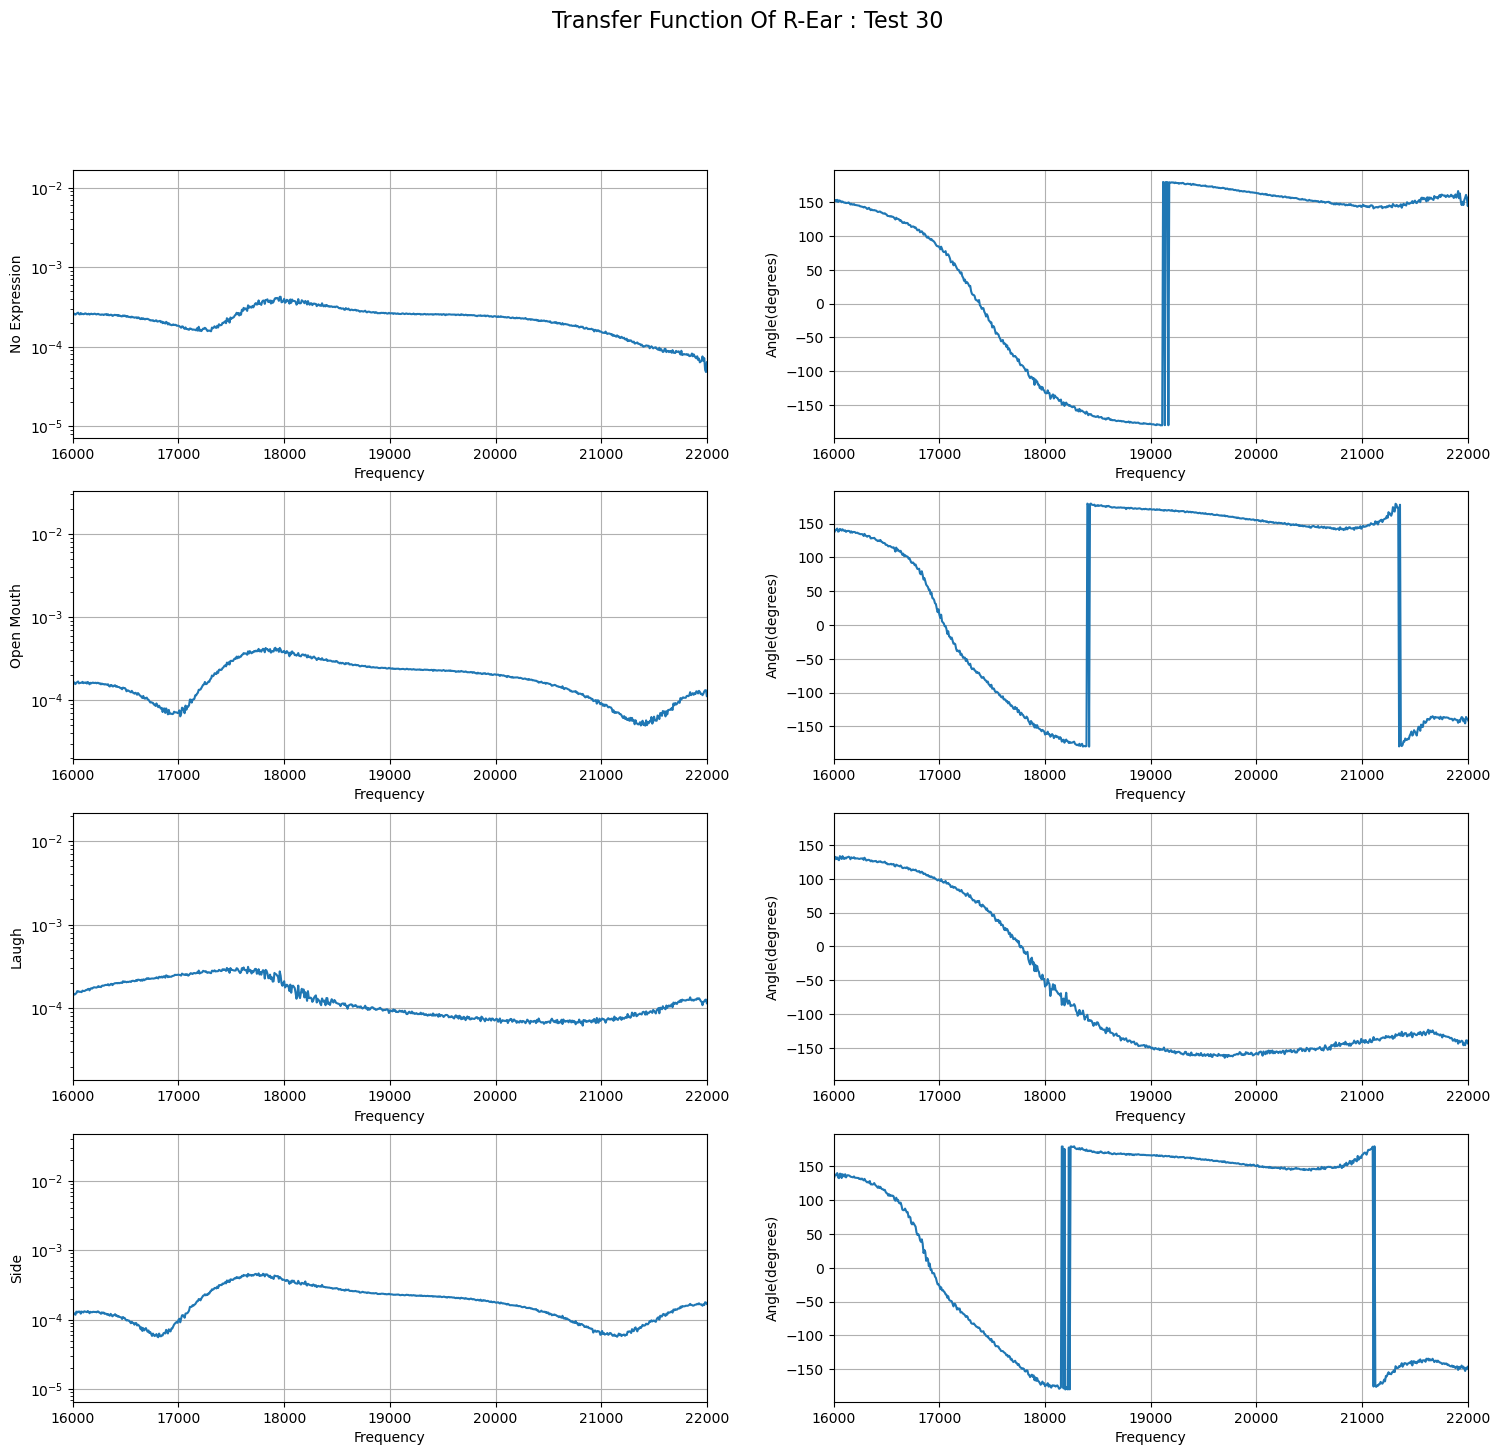

In [1087]:
fig, axs = plt.subplots(4, 2,figsize=(18,16))
fig.suptitle('Transfer Function Of R-Ear : Test '+Tes_no, fontsize=16)

axs[0,0].semilogy(xf,(2/N)*abs(TF_relax_B[:N//2]))
axs[0,0].set_xlim((F_min,F_max))
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_ylabel('No Expression')
axs[0,0].grid(True)

axs[0,1].plot(xf,(180/np.pi)*np.angle(TF_relax_B[:N//2]))
axs[0,1].set_xlim((F_min,F_max))
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Angle(degrees)')
axs[0,1].grid(True)

axs[1,0].semilogy(xf,(2/N)*abs(TF_OpM_B[:N//2]))
axs[1,0].set_xlim((F_min,F_max))
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_ylabel('Open Mouth')
axs[1,0].grid(True)

axs[1,1].plot(xf,(180/np.pi)*np.angle(TF_OpM_B[:N//2]))
axs[1,1].set_xlim((F_min,F_max))
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Angle(degrees)')
axs[1,1].grid(True)

axs[2,0].semilogy(xf,(2/N)*abs(TF_Laugh_B[:N//2]))
axs[2,0].set_xlim((F_min,F_max))
axs[2,0].set_xlabel('Frequency')
axs[2,0].set_ylabel('Laugh')
axs[2,0].grid(True)

axs[2,1].plot(xf,(180/np.pi)*np.angle(TF_Laugh_B[:N//2]))
axs[2,1].set_xlim((F_min,F_max))
axs[2,1].set_xlabel('Frequency')
axs[2,1].set_ylabel('Angle(degrees)')
axs[2,1].grid(True)

axs[3,0].semilogy(xf,(2/N)*abs(TF_Side_B[:N//2]))
axs[3,0].set_xlim((F_min,F_max))
axs[3,0].set_xlabel('Frequency')
axs[3,0].set_ylabel('Side')
axs[3,0].grid(True)

axs[3,1].plot(xf,(180/np.pi)*np.angle(TF_Side_B[:N//2]))
axs[3,1].set_xlim((F_min,F_max))
axs[3,1].set_xlabel('Frequency')
axs[3,1].set_ylabel('Angle(degrees)')
axs[3,1].grid(True)

plt.savefig("Attemp 2\Results\TF_R "+Tes_no+".png")

plt.show()

Saving TF data

In [1088]:
import numpy as np
import csv

# Extrancting important frequency domain data
array1 = filting(10*np.log10(abs(TF_relax_A)),X_f)[1900:2699]
array2 = filting(10*np.log10(abs(TF_OpM_A)),X_f)[1900:2699]
array3 = filting(10*np.log10(abs(TF_Laugh_A)),X_f)[1900:2699]
array4 = filting(10*np.log10(abs(TF_Side_A)),X_f)[1900:2699]

# Combine arrays into a single 2D array
combined_array = np.column_stack((array1, array2, array3, array4))

# Define the file path and name
file_path = 'Attemp 2/output/TF'+Tes_no+'.csv'

# Write arrays to a CSV file
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write column headers (optional)
    writer.writerow(['Relax', 'OpenMouth', 'Laugh', 'Side'])
    
    # Write array data
    writer.writerows(combined_array)

Saving Envelop data

In [1089]:
import numpy as np
import csv

# Extrancting important frequency domain data

# Combine arrays into a single 2D array
combined_array = np.column_stack((env_relax_A, env_opm_A, env_laugh_A, env_side_A))

# Define the file path and name
file_path = 'outputEnv/Envelop'+Tes_no+'.csv'

# Write arrays to a CSV file
with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write column headers (optional)
    writer.writerow(['Relax', 'OpenMouth', 'Laugh', 'Side'])
    
    # Write array data
    writer.writerows(combined_array)


In [1090]:
y_relax_A , y_relax_B = (ifft(Transmit_f * TF_relax_A)) , (ifft(Transmit_f * TF_relax_B))
y_opm_A , y_opm_B = (ifft(Transmit_f * TF_OpM_A)) , (ifft(Transmit_f * TF_OpM_B))
y_laugh_A , y_laugh_B = (ifft(Transmit_f * TF_Laugh_A)) , (ifft(Transmit_f * TF_Laugh_B))
y_side_A , y_side_B = (ifft(Transmit_f * TF_Side_A)) , (ifft(Transmit_f * TF_Side_B))

C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_1164\3353967795.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_relax_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_1164\3353967795.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(y_relax_B.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_1164\3353967795.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_opm_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
C:\Users\lshyamalma\AppData\Local\Temp\ipykernel_1164\3353967795.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  Xf_B = librosa

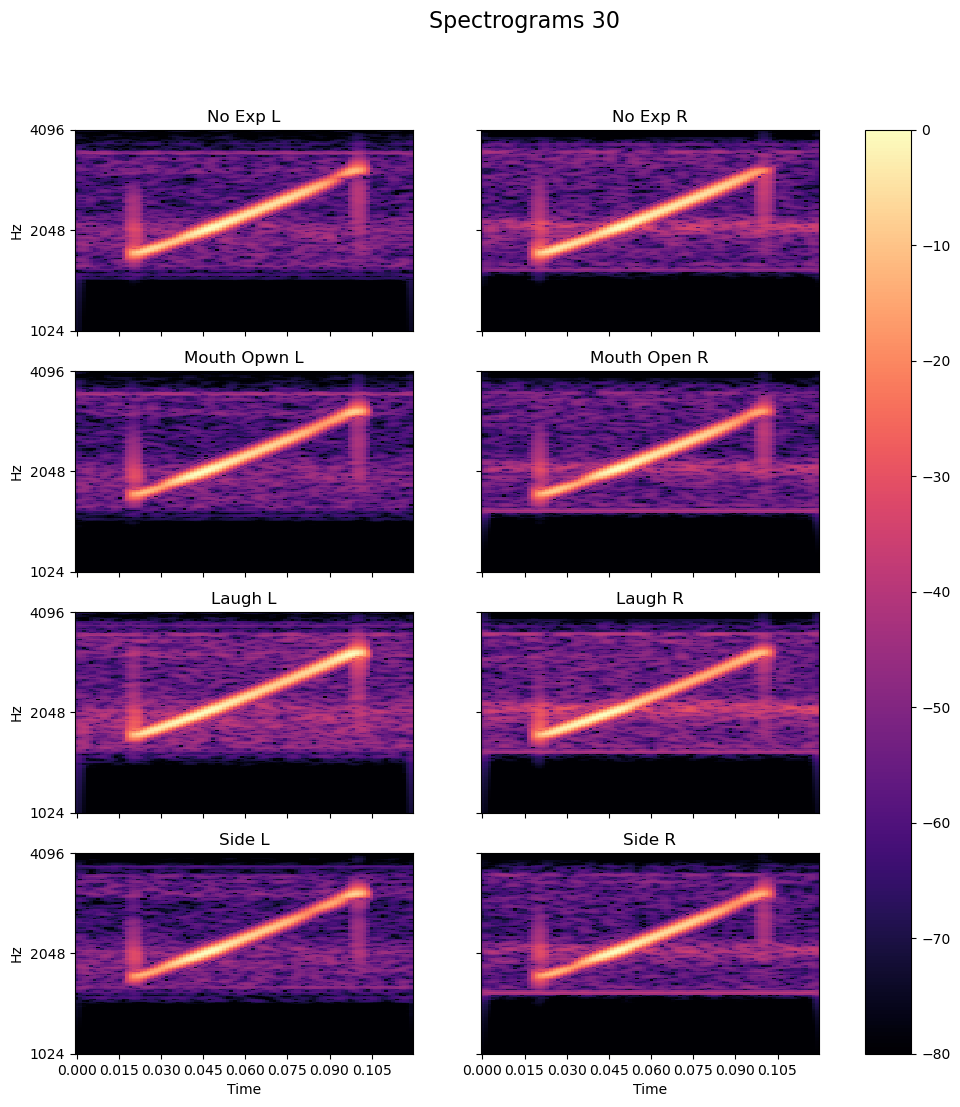

In [1091]:
frameSize = 1024
hopSize = 128


fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(12,12),sharex=True,sharey=True)
fig.suptitle('Spectrograms '+Tes_no, fontsize=16)

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_relax_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[0,0])
ax[0,0].set(title='No Exp L')
ax[0,0].set_ylim((1024,4096))
ax[0,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(y_relax_B.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[0,1],key='Eb:maj')
ax[0,1].set(title='No Exp R')
ax[0,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_opm_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[1,0])
ax[1,0].set(title='Mouth Opwn L')
ax[1,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(y_opm_B.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[1,1],key='Eb:maj')
ax[1,1].set(title='Mouth Open R')
ax[1,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_laugh_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[2,0])
ax[2,0].set(title='Laugh L')
ax[2,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(y_laugh_B.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[2,1],key='Eb:maj')
ax[2,1].set(title='Laugh R')
ax[2,1].label_outer()

Xf_A = librosa.amplitude_to_db(np.abs(librosa.stft(y_side_A.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_A, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize, ax=ax[3,0])
ax[3,0].set(title='Side L')
ax[3,0].label_outer()

Xf_B = librosa.amplitude_to_db(np.abs(librosa.stft(y_side_B.astype(float), n_fft = frameSize, hop_length = hopSize)), ref=np.max)
img = librosa.display.specshow(Xf_B, y_axis='mel', x_axis='time',sr=Fs, hop_length = hopSize , ax=ax[3,1],key='Eb:maj')
ax[3,1].set(title='Side R')
ax[3,1].label_outer()

plt.savefig("LFCC\Mel_Specgrams "+Tes_no+".png")

fig.colorbar(img, ax=ax)

In [1092]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    #axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    S_dB = librosa.amplitude_to_db(specgram , ref=np.max)
    #im = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=10000, ax=axs)                 
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    #plt.savefig()
    plt.show(block=False)

c:\Users\lshyamalma\AppData\Local\anaconda3\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


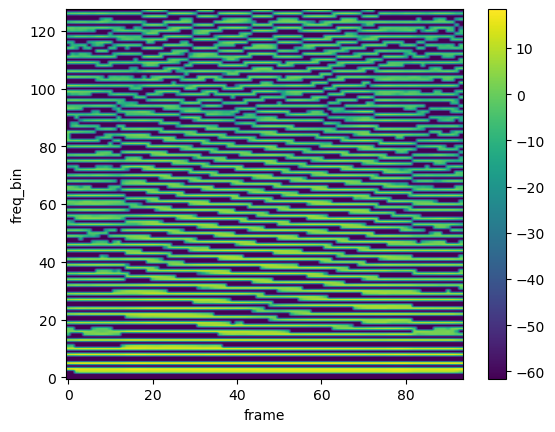

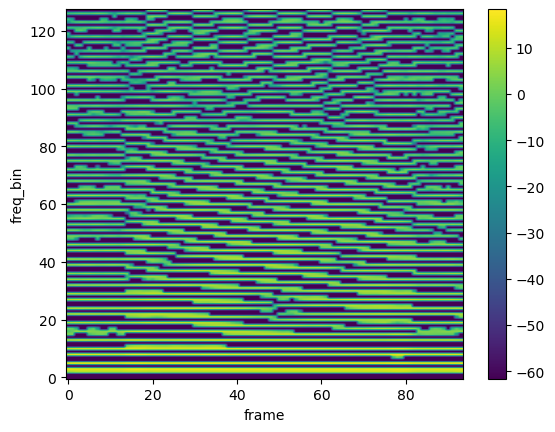

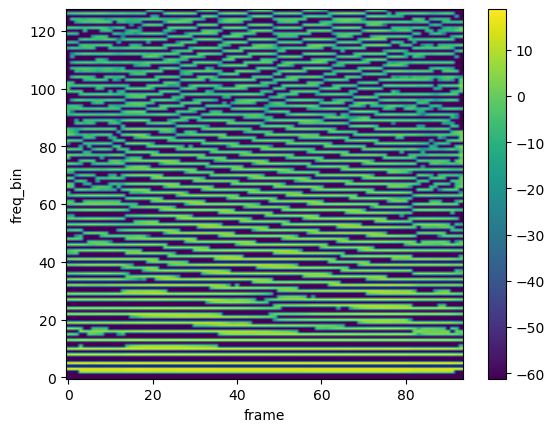

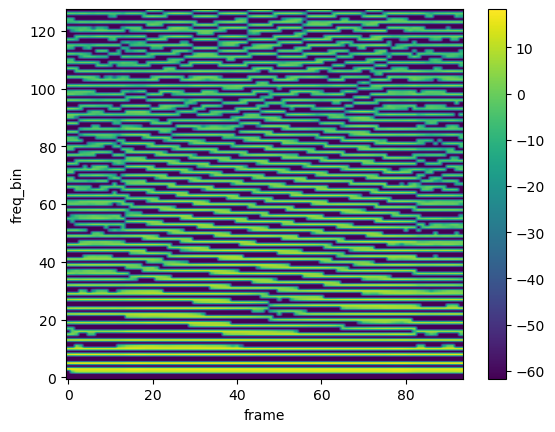

In [1093]:
# n_fft = 512
# win_length = None
# hop_length = 256
# n_lfcc = 256

# lfcc_transform = torchaudio.transforms.LFCC(
#     sample_rate=sampling_rate,
#     n_lfcc=n_lfcc,
#     speckwargs={
#         "n_fft": n_fft,
#         "win_length": win_length,
#         "hop_length": hop_length,
#     },
# )

n_fft = 1024
win_length = None
hop_length = 128
n_mels = 128
n_mfcc = 128

lfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sampling_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)



lfcc_relax_A = lfcc_transform(torch.tensor(np.array([y_relax_A]), dtype=torch.float)) 
lfcc_relax_B = lfcc_transform(torch.tensor(np.array([y_relax_B]), dtype=torch.float))
plot_spectrogram(lfcc_relax_A[0])


lfcc_opm_A , lfcc_relax_B = lfcc_transform(torch.tensor(np.array([y_opm_A]), dtype=torch.float)) , lfcc_transform(torch.tensor(np.array([y_relax_B]), dtype=torch.float))
plot_spectrogram(lfcc_opm_A[0])


lfcc_laugh_A , lfcc_relax_B = lfcc_transform(torch.tensor(np.array([y_laugh_A]), dtype=torch.float)) , lfcc_transform(torch.tensor(np.array([y_relax_B]), dtype=torch.float))
plot_spectrogram(lfcc_laugh_A[0])


lfcc_side_A , lfcc_relax_B = lfcc_transform(torch.tensor(np.array([y_side_A]), dtype=torch.float)) , lfcc_transform(torch.tensor(np.array([y_relax_B]), dtype=torch.float))
plot_spectrogram(lfcc_side_A[0])